# HM04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cluster import KMeans
import sklearn

from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load the data
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
list(data.columns.values)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

## 0. Data Cleaning

### 0.1 NaN Values

In [5]:
def columns_nanValues(data):
    # print all columns with at least one NaN value
    l = list()
    for c in data:
        if data[c].hasnans:
            l.append(c)
    return l

columns_nanValues(data)

['height',
 'weight',
 'position',
 'photoID',
 'rater1',
 'rater2',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

**Remove entries with no Skin Color feature**

Some columns contains NaN values. For this homework, we will not be able to work with data having no *skin color* feature. Therefore we only keep instances with this information.

In [6]:
# We remove all instance with no 'photoID' information, since the skin color needs this information
data_clean = data[~data.photoID.isnull()]
nan_col = columns_nanValues(data_clean)
nan_col

['height',
 'weight',
 'position',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

In [7]:
data_clean[nan_col].dtypes

height      float64
weight      float64
position     object
Alpha_3      object
meanIAT     float64
nIAT        float64
seIAT       float64
meanExp     float64
nExp        float64
seExp       float64
dtype: object

**Percentage of NaN cells per column**

In [8]:
for x in nan_col:
    nbr = data_clean[x].isnull().sum()
    print(x, '-->', nbr)
    print("   Total percentage: ", nbr/len(data_clean)*100)

Number of NaNs values per column:
height --> 46
   Total percentage:  0.0369119169321
weight --> 753
   Total percentage:  0.60423203152
position --> 8461
   Total percentage:  6.78938541658
Alpha_3 --> 1
   Total percentage:  0.000802432976786
meanIAT --> 153
   Total percentage:  0.122772245448
nIAT --> 153
   Total percentage:  0.122772245448
seIAT --> 153
   Total percentage:  0.122772245448
meanExp --> 153
   Total percentage:  0.122772245448
nExp --> 153
   Total percentage:  0.122772245448
seExp --> 153
   Total percentage:  0.122772245448


For the values related to the *IAT* and *Exp*, we decided to remove those rows, since they are, for us, the more relevant of all in relation to a possible racism from refs to players.

In [9]:
data_clean = data_clean[~data_clean.nIAT.isnull()]
# Colums still have NaN values
nan_col = columns_nanValues(data_clean)
nan_col

['height', 'weight', 'position']

### 0.2 Dealing with missing data

**Potential fixes to missing cells**

We know that there are multiple entries per player in our dataset. Therefore, is it possible that the information about *weight*, *height*, or *position* for a player is missing in one entry but present in another ? If yes, we could simply replace the missing values by the ones present in another row, but as we can see, such case doesn't occur.

In [10]:
# Assert if any missing values for a player feature
# are not present in another row

for col in nan_col:
    data_noWeight = data_clean[data_clean[col].isnull()]
    data_withWeight = data_clean[~data_clean[col].isnull()]

    i1 = list(data_noWeight.index)
    i2 = list(data_withWeight.index)

    nbr = [x for x in i1 if x in i2]
    print(col, '-->', nbr)

height --> []
weight --> []
position --> []


**Drop rows or fill mean values to the cell**

Now we are sure that there is no way to recover this values. We have therefore two possibilities:
- Replace the missing *height* and *weight* values by the mean of all players
- Remove the rows with missing values

We've decided to go for the second option, as the percentage of data concern is low (then tha 1%)

In [11]:
nan_values_to_drop = ['weight', 'height']
for col in nan_values_to_drop:
    data_clean = data_clean[~data_clean[col].isnull()]

In [12]:
# Last feature to clean
columns_nanValues(data_clean)

['position']

There is still one remaining feature for which we need to clean. For the *position* column, we can:

- Replace all missing entries by a *dummy* variable, like "Unknown"
- Replace all missing entries by the most frequent one according to the rest entries (*position* is not numerical, therefore no mean)
- Remove the rows with missing values

We decide to remove those rows. But before doing so, we want to assert that we aren't throwing valuable information. We compare the skin color rated by *rater1* and *rater2* column with NaN value against the data witouh NaN values.

In [13]:
# Data WITH NaNs values
nan_data = data_clean[data_clean.position.isnull()]
print(nan_data.rater1.describe())
print('----')
print(nan_data.rater2.describe())

count    8258.000000
mean        0.287600
std         0.297938
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater1, dtype: float64
----
count    8258.000000
mean        0.324837
std         0.313449
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater2, dtype: float64


In [14]:
# Data WITHOUT NaNs values
good_data = data_clean[~data_clean.position.isnull()]
print(good_data.rater1.describe())
print('----')
print(good_data.rater2.describe())

count    115457.000000
mean          0.261946
std           0.294666
min           0.000000
25%           0.000000
50%           0.250000
75%           0.250000
max           1.000000
Name: rater1, dtype: float64
----
count    115457.000000
mean          0.300796
std           0.291061
min           0.000000
25%           0.000000
50%           0.250000
75%           0.500000
max           1.000000
Name: rater2, dtype: float64


**Remove rows with empty position information based on observation of skin color rating comparison**

As we cann see, there is no major difference between the two portions of data. Therefore, we have decided to remove these rows.

In [15]:
# Remove all entries with NaNs values in the 'position' column
data_clean = data_clean[~data_clean.position.isnull()]

In [164]:
# Assert no more "NaN" values in our dataframe
columns_nanValues(data_clean)

[]

### 0.3 Tuning the SkinColor feature

The *skin color* feature is stored in two columns: *rater1* and *rater2*. Based on these two columns, we create a new feature *skinColor* by aggregating the two results. But before, let's take a look on the raters results.

In [17]:
data_skin = data_clean
data_skin["skinColorDiff"] = (data_skin.rater1-data_skin.rater2).abs()

It's obvious that the two raters aren't always on the same page, therefore it is natural to have different results for the same player.

In [18]:
# Search if there are entries where rater rating differ more than 0.25
data_colorDiff = data_skin[data_skin.skinColorDiff > 0.25]
len(data_colorDiff)

164

For 164 entries, the two raters have split opinions.

In [19]:
print(data_colorDiff.rater1.unique())
print(data_colorDiff.rater2.unique())

[ 0.]
[ 0.5]


**Keep entries with consistent skin ratings**

**Reason:** When one rater consider the player's skin as *very light skin* and the other as *neither dark not light skin*. The number of these entries are small comparing to the entire dataset and any attemp to make a compromise of the two and leaving these entries in might raise the bias of the outcome of our classifier, we've decided that those entries aren't reliable and therefore remove it.

In [165]:
## Display the total number of entries
data_skin_clean = data_skin[data_skin.skinColorDiff <= 0.25]
len(data_skin_clean)

115293

**Merge two columns in one**

Now we can create the *skinColor* feature by aggregating the two raters results.

In [21]:
# Add the skin color based on the two raters
data_skin_clean["skinColor"] = (data_skin.rater1+data_skin.rater2)/2

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 0.4 Remove referees

Now we need to look a little more into the referees features. As mentionned in the [complementary reading](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) for this assignement, there are some referees in this dataset who have less than 22 dyads. Since we want to take into consideration only games in the four leagues (England, France, Germany, and Spain), we need to remove all dyads where a referee has less that 22 games. Note that these doesn't mean we remove all possible ref-related noise of our data.

In [22]:
# Group the data by refs
data_by_refs = data_skin_clean.groupby('refNum').size()
refsToKeep = data_by_refs >= 22

# Retrieve the 'refNum' of refs to keep in the data
refsToKeepID = list()
for i,x in enumerate(refsToKeep):
    if x:
        refsToKeepID.append(refsToKeep.index[i])

# Keep only the refs with at least 22 games
data_clean = data_skin_clean[data_skin_clean.refNum.isin(refsToKeepID)]

In [23]:
data = data_clean
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.000


## 1.
>Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

### 1.1 Cross-Featuring
For this first part, we only care about player description. Therefore, we need to keep only one entry per player and for each player to aggregate his data with all refs with who he has a dyad.

In [24]:
data_by_player = data.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'player'    : 'first',
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum all referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
        
        'meanIAT'   : 'mean',
        'meanExp'   : 'mean',
        'seIAT'     : 'mean',
        'seExp'     : 'mean'
    })

data_player.head()

,redCards,victories,height,defeats,seIAT,weight,meanExp,seExp,games,club,leagueCountry,birthday,meanIAT,player,ties,yellowReds,goals,skinColor,position,yellowCards
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0,240,182.0,221,0.000282,71.0,0.484931,0.001321,635,Fulham FC,England,08.11.1979,0.345065,Aaron Hughes,174,0,8,0.125,Center Back,19
aaron-hunt,1,139,183.0,119,0.000227,73.0,0.451448,0.001032,328,Werder Bremen,Germany,04.09.1986,0.349424,Aaron Hunt,70,0,59,0.125,Attacking Midfielder,39
aaron-lennon,0,200,165.0,115,0.000371,63.0,0.492832,0.002052,411,Tottenham Hotspur,England,16.04.1987,0.346085,Aaron Lennon,96,0,31,0.250,Right Midfielder,11
aaron-ramsey,1,144,178.0,67,0.000496,76.0,0.511374,0.002826,253,Arsenal FC,England,26.12.1990,0.347013,Aaron Ramsey,42,0,39,0.000,Center Midfielder,31
abdelhamid-el-kaoutari,2,41,180.0,43,0.001488,73.0,0.335587,0.005296,124,Montpellier HSC,France,17.03.1990,0.331600,Abdelhamid El-Kaoutari,40,4,1,0.250,Center Back,8


#### 1.1.1 IAT and Exp
There is still some columns that we can aggregate from the original dataset. We decided to combine the *meanIAT* and *meanExp* together, and the *seIAT* with the *seExp*.

In [25]:
# Before aggregatins the IAT and Exp data together, we decided to change the data
# in order to have values between [0,1]

def column_maxmin(column):
    """
        Normalize the column values in a given dataframe
    """
    maxmin = column.max() - column.min()
    return (column - column.min()) / maxmin


data_player.meanIAT = column_maxmin(data_player.meanIAT)
data_player.seIAT   = column_maxmin(data_player.seIAT)
data_player.meanExp = column_maxmin(data_player.meanExp)
data_player.seExp   = column_maxmin(data_player.seExp)

In [26]:
data_player["meanIATEXP"] = (data_player.meanIAT + data_player.meanExp) / 2
data_player["seIATEXP"] = (data_player.seIAT**2 + data_player.seExp**2)**0.5
data_player.head()

,redCards,victories,height,defeats,seIAT,weight,meanExp,seExp,games,club,...,meanIAT,player,ties,yellowReds,goals,skinColor,position,yellowCards,meanIATEXP,seIATEXP
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0,240,182.0,221,0.030137,71.0,0.434369,0.028156,635,Fulham FC,...,0.527935,Aaron Hughes,174,0,8,0.125,Center Back,19,0.481152,0.041243
aaron-hunt,1,139,183.0,119,0.024027,73.0,0.399713,0.021812,328,Werder Bremen,...,0.567933,Aaron Hunt,70,0,59,0.125,Attacking Midfielder,39,0.483823,0.032451
aaron-lennon,0,200,165.0,115,0.039880,63.0,0.442548,0.044180,411,Tottenham Hotspur,...,0.537290,Aaron Lennon,96,0,31,0.250,Right Midfielder,11,0.489919,0.059518
aaron-ramsey,1,144,178.0,67,0.053753,76.0,0.461739,0.061155,253,Arsenal FC,...,0.545806,Aaron Ramsey,42,0,39,0.000,Center Midfielder,31,0.503773,0.081421
abdelhamid-el-kaoutari,2,41,180.0,43,0.163288,73.0,0.279791,0.115304,124,Montpellier HSC,...,0.404375,Abdelhamid El-Kaoutari,40,4,1,0.250,Center Back,8,0.342083,0.199895


#### 1.1.2  Cards
Players can receive a yellow card, a red card resulting of two yellows one, or a direct red card. 

We've decided to combine these cards features:
- *cardsPerGame*: Sum of all cards divided by the number of games
- *yellowCardNorm*: The number of yellow cards for a player divided by the total number of yellow cards (for all players). Between [0,1]
- *yellowRedsNorm*: Same as *yellowCardStand*, but with the yellowReds
- *redCardsNorm*: Same as *yellowCardStand*, but with the redCards

In [27]:
# cardsPerGame
data_player['cardsPerGame'] = (data_player.yellowCards + data_player.yellowReds + data_player.redCards)\
                                / data_player.games

In [28]:
#yellowCardNorm
data_player['yellowCardNorm'] = data_player.yellowCards / data_player.yellowCards.sum()
data_player['yellowCardNorm'] = column_maxmin(data_player['yellowCardNorm'])

In [29]:
#yellowRedsNorm
data_player['yellowRedsNorm'] = data_player.yellowReds / data_player.yellowReds.sum()
data_player['yellowRedsNorm'] = column_maxmin(data_player['yellowRedsNorm'])

In [30]:
#redCardsNorm
data_player['redCardsNorm'] = data_player.redCards / data_player.redCards.sum()
data_player['redCardsNorm'] = column_maxmin(data_player['redCardsNorm'])

In [31]:
data_player.head()

,redCards,victories,height,defeats,seIAT,weight,meanExp,seExp,games,club,...,goals,skinColor,position,yellowCards,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0,240,182.0,221,0.030137,71.0,0.434369,0.028156,635,Fulham FC,...,8,0.125,Center Back,19,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000
aaron-hunt,1,139,183.0,119,0.024027,73.0,0.399713,0.021812,328,Werder Bremen,...,59,0.125,Attacking Midfielder,39,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909
aaron-lennon,0,200,165.0,115,0.039880,63.0,0.442548,0.044180,411,Tottenham Hotspur,...,31,0.250,Right Midfielder,11,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000
aaron-ramsey,1,144,178.0,67,0.053753,76.0,0.461739,0.061155,253,Arsenal FC,...,39,0.000,Center Midfielder,31,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909
abdelhamid-el-kaoutari,2,41,180.0,43,0.163288,73.0,0.279791,0.115304,124,Montpellier HSC,...,1,0.250,Center Back,8,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818


#### 1.1.3 Cards & IATEXP

We want to create a feature by combing the cards and the IAT and Exp data. Therefore, we create a new feature:
- *cardsIATExp* = (yellowCardNorm + yellowRedsNorm + redCardsNorm) * meanIATEXP

In [32]:
data_player['cardsIATExp'] = (data_player.yellowCardNorm + data_player.yellowRedsNorm + data_player.redCardsNorm) \
                                * data_player.meanIATEXP
    
data_player.head()

,redCards,victories,height,defeats,seIAT,weight,meanExp,seExp,games,club,...,skinColor,position,yellowCards,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0,240,182.0,221,0.030137,71.0,0.434369,0.028156,635,Fulham FC,...,0.125,Center Back,19,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000,0.048887
aaron-hunt,1,139,183.0,119,0.024027,73.0,0.399713,0.021812,328,Werder Bremen,...,0.125,Attacking Midfielder,39,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909,0.144888
aaron-lennon,0,200,165.0,115,0.039880,63.0,0.442548,0.044180,411,Tottenham Hotspur,...,0.250,Right Midfielder,11,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000,0.028819
aaron-ramsey,1,144,178.0,67,0.053753,76.0,0.461739,0.061155,253,Arsenal FC,...,0.000,Center Midfielder,31,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909,0.129311
abdelhamid-el-kaoutari,2,41,180.0,43,0.163288,73.0,0.279791,0.115304,124,Montpellier HSC,...,0.250,Center Back,8,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818,0.190859


### 1.2 Convert columns types

As seen previously, some of our columns have the *object* type. Since the library we are using doesn't deal with this type of column values, we need to change it by using a *LabelEncoder()*

In [33]:
def columnEncoder(df, col):
    """
    Replace all values of a column by applying the 'LabelEncoder' form 'sklearn'
    
    INPUT:
        df: The dataframe containing the columns to change
        col: The column name over which the 'LabelEncoder' will be applied
        
    OUTPUT:
        The dataframe with news values in the specified column
    """
    labelEncoder = preprocessing.LabelEncoder()
    df[col] = labelEncoder.fit_transform(df[col])

In [34]:
data_player.dtypes

redCards            int64
victories           int64
height            float64
defeats             int64
seIAT             float64
weight            float64
meanExp           float64
seExp             float64
games               int64
club               object
leagueCountry      object
birthday           object
meanIAT           float64
player             object
ties                int64
yellowReds          int64
goals               int64
skinColor         float64
position           object
yellowCards         int64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

In [35]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now all the columns are numbers, but we have decided to work have only *float64* values.

In [36]:
data_player = data_player.astype(float)
data_player.dtypes

redCards          float64
victories         float64
height            float64
defeats           float64
seIAT             float64
weight            float64
meanExp           float64
seExp             float64
games             float64
club              float64
leagueCountry     float64
birthday          float64
meanIAT           float64
player            float64
ties              float64
yellowReds        float64
goals             float64
skinColor         float64
position          float64
yellowCards       float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

### 1.3 Prepare data for ML

In [37]:
X = data_player.drop('skinColor', axis=1)

The assignement asked us to use the *RandomForestClassifier*. Therefore, we need to work with discrete values. We've decided to add a new column to our data: *isBlack*. This column takes the value *True* if the *skinColor* average of the two raters is bigger than 0.5.

Note that if *isBlack* is false, it doesn't mean that the player has light skin (can be *neither dark nor light skin*).

In [38]:
data_player['isBlack'] = data_player["skinColor"] > 0.5
y = data_player['isBlack']

### 1.4 Random Forest Classifier - Assert model

As specified in the assignement, we use *cross-validation* with the *radom forest classifier* to perform our prediction, therefore mitigating the overfitting of the model.

We start by choosing the best parameters for our classifier. We've decided to tune two parameters of the scikit RandomForestClassifier:
- n_estimators
- max_features

#### 1.4.1 n_estimators

In [39]:
n_range = range(1,100)
scores = list()

max_scores = -1
best_n = -1

for i in n_range:
    ml = RandomForestClassifier(n_estimators=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
    if (i%10==0):
        print(i, cross.mean())
        
# Best values
print("Best",best_n, max_scores)

10 0.854508469255
20 0.849583957647
30 0.855217760463
40 0.855927051672
50 0.856626282518
60 0.858738958574
70 0.857325513364
80 0.853799392097
90 0.849563979622
Best 61 0.859448178432


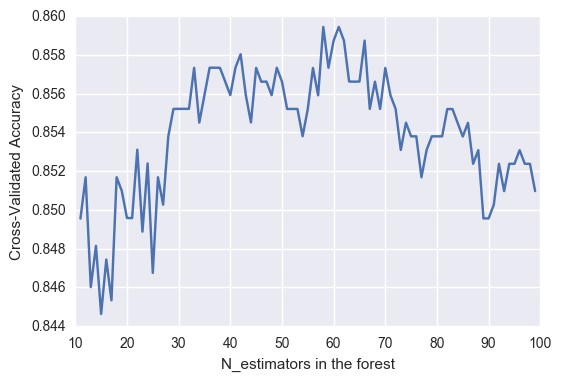

In [40]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_range[10:], scores[10:])
plt.xlabel('N_estimators in the forest')
plt.ylabel('Cross-Validated Accuracy')

#### 1.4.2 max_features

In [41]:
max_features = range(1,len(X.columns))
scores = list()

max_scores = -1
best_n = -1

for i in max_features:
    ml = RandomForestClassifier(max_features=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
# Best values
print(best_n, max_scores)

9 0.859468227807


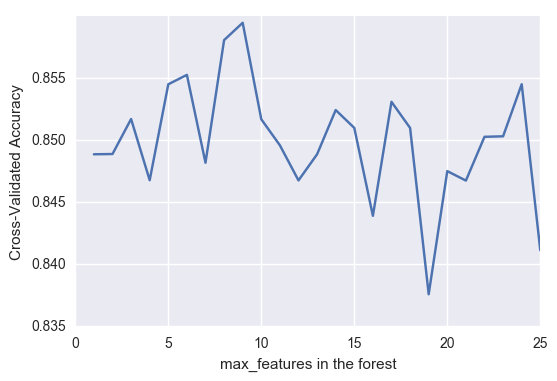

In [42]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_features, scores)
plt.xlabel('max_features in the forest')
plt.ylabel('Cross-Validated Accuracy')

We see that the best option here is 5, which is roughly the square root of the numbers of features.

#### 1.4.3 Model with ALL features

In [43]:
def RFCmodel_cv_featureImportance(X,y):
    """
        Compute the RandomForestClassifier for features dataframe X and classes features y.
        It prints the accuracy of the model using cross-validation and a graph displaying
        the importance for each features.
    """
    
    ml = RandomForestClassifier(n_estimators=51, max_features=5, random_state=1)

    # Cross-validation accuracy
    cross = (cross_val_score(ml, X, y, cv=10))
    print("Cross-validation:", cross.mean())

    # Feature importance
    ml.fit(X,y)
    feature_importance = ml.feature_importances_

    # Combining the features_importance array with the corresponding feature name
    l1 = list(zip(feature_importance, X.columns))
    l1.sort(key=lambda x: x[0], reverse=True)
    features = list(map(lambda x: x[0], l1))
    features_names = list(map(lambda x: x[1], l1))

    # Plot the features_importances graph
    graph = sns.barplot(features_names, features, palette='BuGn_r')
    graph.set_title("Features importance")
    graph.set_xticklabels(labels=features_names, rotation=90)
    plt.show()
    
    
    # Print confusion_matrix
    y_predicted = cross_val_predict(ml, X, y, cv=10)
    cm = metrics.confusion_matrix(y, y_predicted)
    print(cm)
    print("Confusion matrix")
    print("White as white: ", cm[0][0])
    print("White as black: ", cm[0][1])
    print("black as white: ", cm[1][0])
    print("black as black: ", cm[1][1])

Cross-validation: 0.855212837308


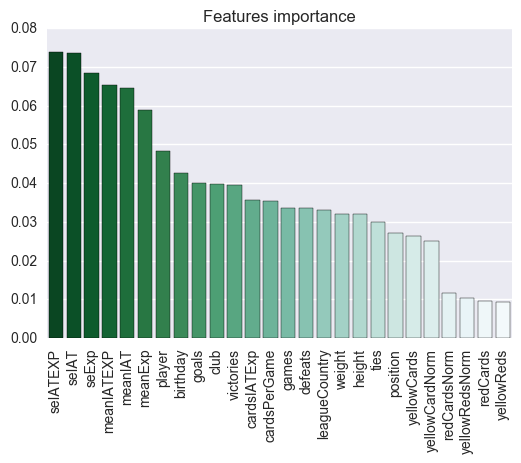

[[1156   33]
 [ 172   55]]
Confusion matrix
White as white:  1156
White as black:  33
black as white:  172
black as black:  55


In [44]:
RFCmodel_cv_featureImportance(X,y)

**BLA BLA BLA **

#### 1.4.4 Model with some selected features

Now we decided to run the model but with some arbitrarily-selected features.

In [45]:
list(data_player.columns)

['redCards',
 'victories',
 'height',
 'defeats',
 'seIAT',
 'weight',
 'meanExp',
 'seExp',
 'games',
 'club',
 'leagueCountry',
 'birthday',
 'meanIAT',
 'player',
 'ties',
 'yellowReds',
 'goals',
 'skinColor',
 'position',
 'yellowCards',
 'meanIATEXP',
 'seIATEXP',
 'cardsPerGame',
 'yellowCardNorm',
 'yellowRedsNorm',
 'redCardsNorm',
 'cardsIATExp',
 'isBlack']

In [46]:
features_to_keep = [
    "leagueCountry",
    "club",
    "weight",
    "height",
    "games",
    "position",
    "birthday",
    'meanIATEXP',
    'seIATEXP',
    'cardsPerGame',
    'yellowCardNorm',
    'yellowRedsNorm',
    'redCardsNorm',
    'cardsIATExp',
]

X = data_player[features_to_keep]

Cross-validation: 0.858748876236


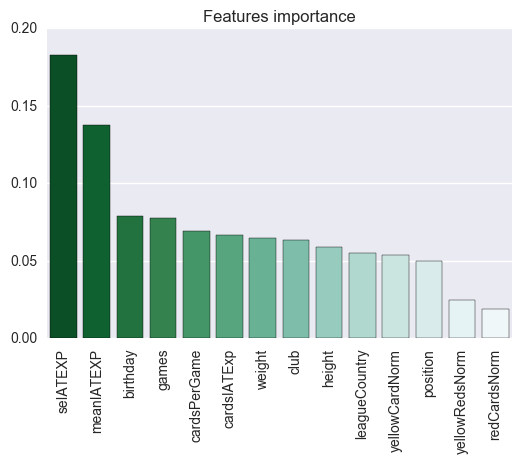

[[1165   24]
 [ 176   51]]
Confusion matrix
White as white:  1165
White as black:  24
black as white:  176
black as black:  51


In [47]:
RFCmodel_cv_featureImportance(X,y)

Cross-validation: 0.862270074347


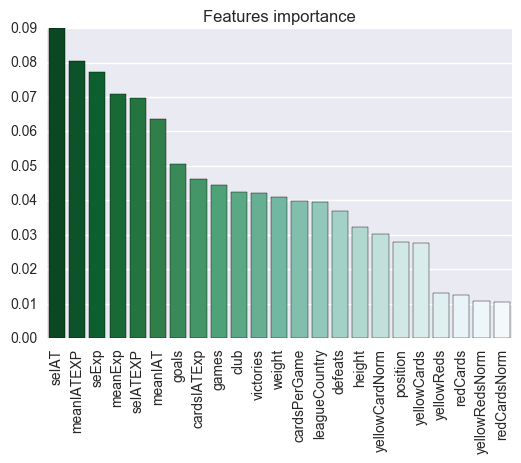

[[1158   31]
 [ 164   63]]
Confusion matrix
White as white:  1158
White as black:  31
black as white:  164
black as black:  63


In [163]:
features_experiment_1 = [
 'redCards',
 'victories',
 'height',
 'defeats',
 'seIAT',
 'weight',
 'meanExp',
 'seExp',
 'games',
 'club',
 'leagueCountry',
 #'birthday',
 'meanIAT',
 #'player',
 #'ties',
 'yellowReds',
 'goals',
 # 'skinColor',
 'position',
 'yellowCards',
 'meanIATEXP',
 'seIATEXP',
 'cardsPerGame',
 'yellowCardNorm',
 'yellowRedsNorm',
 'redCardsNorm',
 'cardsIATExp',
 # 'isBlack',
]

X_experiment_1 = data_player[features_experiment_1]

RFCmodel_cv_featureImportance(X_experiment_1,y)

Experiment in selected features
1. drop player name, 0.8608 accuracy
2. drop birthday, 0.8615
3. drop ties, 0.8622

# 2.

>Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

### 2.3 Prepare data for ML

#### 2.3.1 Numerical values only

Our datasets has, at the moment, different types per column

In [48]:
data_player.dtypes

redCards          float64
victories         float64
height            float64
defeats           float64
seIAT             float64
weight            float64
meanExp           float64
seExp             float64
games             float64
club              float64
leagueCountry     float64
birthday          float64
meanIAT           float64
player            float64
ties              float64
yellowReds        float64
goals             float64
skinColor         float64
position          float64
yellowCards       float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
isBlack              bool
dtype: object

In [49]:
data_player.head()

,redCards,victories,height,defeats,seIAT,weight,meanExp,seExp,games,club,...,position,yellowCards,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp,isBlack
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.0,240.0,182.0,221.0,0.030137,71.0,0.434369,0.028156,635.0,33.0,...,1.0,19.0,0.481152,0.041243,0.029921,0.101604,0.000000,0.000000,0.048887,False
aaron-hunt,1.0,139.0,183.0,119.0,0.024027,73.0,0.399713,0.021812,328.0,85.0,...,0.0,39.0,0.483823,0.032451,0.121951,0.208556,0.000000,0.090909,0.144888,False
aaron-lennon,0.0,200.0,165.0,115.0,0.039880,63.0,0.442548,0.044180,411.0,78.0,...,10.0,11.0,0.489919,0.059518,0.026764,0.058824,0.000000,0.000000,0.028819,False
aaron-ramsey,1.0,144.0,178.0,67.0,0.053753,76.0,0.461739,0.061155,253.0,6.0,...,3.0,31.0,0.503773,0.081421,0.126482,0.165775,0.000000,0.090909,0.129311,False
abdelhamid-el-kaoutari,2.0,41.0,180.0,43.0,0.163288,73.0,0.279791,0.115304,124.0,48.0,...,1.0,8.0,0.342083,0.199895,0.112903,0.042781,0.333333,0.181818,0.190859,False


#### 2.3.3 Binary SkinColor

In order be able to make comparison between the classifier and the skinColor of a player, we need to have the skin information stored as a binary value.

We add a new column to our dataset: *blackSkin*. It will take value 0 if the skin is defined as *non-black* and value 1 otherwise.

In [50]:
data_player['blackSkin'] = -1
data_player['blackSkin'][data_player.skinColor>0.5] = 1
data_player['blackSkin'][data_player.skinColor<=0.5] = 0

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### 2.4 Unsupervised learning

We have (arbitrarly) decided to work with the *k_means* algorithm from scikit.

Need to remove the two features about the skin color. As stated above, we will use the *blackSkin* feature to compute the percentage of dark and light skin colors in the clusters.

In [51]:
X = data_player.drop(['skinColor', 'blackSkin'], axis=1)
y = data_player.blackSkin

**Demonstration of the method used**

In will, compute which of the features is the best candidate to being removed. If the silhouette score by removing this feature is better than by keeping it, we drop the specific column and go through the loop one more time.

Below, we display a graph that shows the first iteration of the algorithm.

In [52]:
caca = X


scale = StandardScaler().fit(caca)
caca = scale.transform(caca)
caca = pd.DataFrame(caca, columns=X.columns)
caca

,redCards,victories,height,defeats,seIAT,weight,meanExp,seExp,games,club,...,position,yellowCards,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp,isBlack
0,-0.746581,1.748596,-0.024512,3.718841,-0.271660,-0.742844,0.241257,-0.287099,2.875825,-0.411246,...,-1.030168,-0.499568,-0.078180,-0.280618,-1.320715,-0.499568,-0.690851,-0.746581,-0.742052,-0.436940
1,0.014512,0.440688,0.122558,1.152783,-0.388805,-0.461144,-0.145221,-0.406734,0.674529,1.586962,...,-1.341461,0.310264,-0.051114,-0.398942,-0.258475,0.310264,-0.690851,0.014512,-0.150509,-0.436940
2,-0.746581,1.230613,-2.524687,1.052153,-0.084826,-1.869643,0.332461,0.015078,1.269668,1.317972,...,1.771467,-0.823501,0.010662,-0.034672,-1.357157,-0.823501,-0.690851,-0.746581,-0.865709,-0.436940
3,0.014512,0.505436,-0.612788,-0.155404,0.181181,-0.038594,0.546481,0.335183,0.136753,-1.448776,...,-0.407583,-0.013669,0.151053,0.260109,-0.206177,-0.013669,-0.690851,0.014512,-0.246495,-0.436940
4,0.775606,-0.828371,-0.318650,-0.759182,2.281503,-0.461144,-1.482555,1.356285,-0.788221,0.165160,...,-1.030168,-0.944976,-1.487459,1.854568,-0.362910,-0.944976,2.211953,0.775606,0.132758,-0.436940
5,-0.746581,-0.854270,-0.318650,-1.035914,1.025788,-0.320294,-1.519162,0.691829,-1.003332,-0.334391,...,1.771467,-0.823501,-1.431552,0.865393,-0.192587,-0.823501,0.034850,-0.746581,-0.738806,2.288643
6,-0.746581,-1.281606,1.004972,-1.664850,-0.323497,0.524805,-0.542864,-0.392999,-1.533937,1.202691,...,0.215003,-1.268909,-0.513723,-0.357834,-1.666075,-1.268909,-0.690851,-0.746581,-1.043286,2.288643
7,-0.746581,-1.359304,0.857903,-1.790637,0.046347,0.947355,-0.540238,-0.098598,-1.655833,-0.334391,...,0.215003,-1.268909,0.047482,-0.023879,-1.666075,-1.268909,-0.690851,-0.746581,-1.043286,2.288643
8,0.775606,-0.931968,-0.318650,-0.281191,-0.486689,-1.165394,-0.377425,-0.524754,-0.816903,1.125837,...,-0.096290,-0.418585,-0.203149,-0.506028,0.546204,-0.418585,-0.690851,0.775606,-0.193641,2.288643
9,0.014512,-1.139161,-0.465719,-1.212016,-0.464057,-0.883694,-1.188435,-0.409887,-1.318827,1.087410,...,0.526296,-1.147434,-0.866915,-0.438120,-0.742689,-1.147434,-0.690851,0.014512,-0.777491,2.288643


In [53]:
silhouettes = list()

for col in caca.columns:
    data_without_col = caca.drop(col, axis=1)
    
    kmeans = KMeans(n_clusters=2).fit(data_without_col)
    silhouette = sklearn.metrics.silhouette_score(data_without_col, kmeans.labels_)
    
    silhouettes.append(silhouette)
    
    #skin_sep = (kmeans.labels_ == y).sum() / len(y)
    #skin_separations.append(max(skin_sep, 1-skin_sep))

In [54]:
# Add columns names to columns silhouette value and order
l1 = list(zip(silhouettes, X.columns))
l1.sort(key=lambda x: x[0], reverse=True)

sil_values = list(map(lambda x: x[0], l1))
sil_names = list(map(lambda x: x[1], l1))

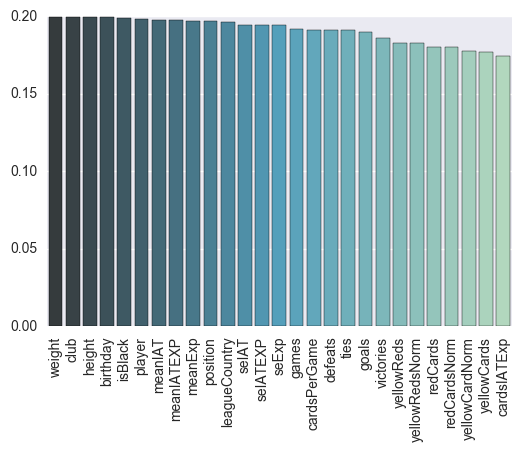

In [55]:
# Plot graph
graph = sns.barplot(sil_names, sil_values, palette='GnBu_d')
graph.set_xticklabels(labels=sil_names, rotation=90)
plt.show()

So here,the leagueCountry feature needs to be remove

NOW, LOOP !

In [56]:
new_data = caca
kmeans = KMeans(n_clusters=2).fit(caca)
data_silhouette = sklearn.metrics.silhouette_score(caca, kmeans.labels_)
        
print("TOUT", data_silhouette)

to_del = "nope"
to_del_min = -1

while True:
    for col in new_data.columns:
        data_without_col = new_data.drop(col, axis=1)

        kmeans = KMeans(n_clusters=2).fit(data_without_col)
        silhouette = sklearn.metrics.silhouette_score\
                        (data_without_col, kmeans.labels_)

        if silhouette > to_del_min:
            to_del = col
            to_del_min = silhouette

        #skin_sep = (kmeans.labels_ == y).sum() / len(y)
        #skin_separations.append(max(skin_sep, 1-skin_sep))
    if to_del_min > data_silhouette:
        new_data = new_data.drop(to_del, axis=1)
        data_silhouette = to_del_min
        print(to_del, "DELETED")

    else:
        break

TOUT 0.190766641193
weight DELETED
club DELETED
birthday DELETED
height DELETED
player DELETED
isBlack DELETED
position DELETED
meanIAT DELETED
leagueCountry DELETED
meanExp DELETED
meanIATEXP DELETED
defeats DELETED
ties DELETED
games DELETED
cardsPerGame DELETED
victories DELETED
goals DELETED
seIAT DELETED
seIATEXP DELETED
seExp DELETED
redCardsNorm DELETED
redCards DELETED
yellowCards DELETED
yellowCardNorm DELETED
cardsIATExp DELETED
yellowReds DELETED


ValueError: Found array with 0 feature(s) (shape=(1416, 0)) while a minimum of 1 is required.